Real-Time Emotion Recognition with Deep Learning
The key steps in this code include:
1. Loading and preprocessing the dataset of facial expressions.
2. Defining and training a CNN model for emotion classification.
3. Evaluating the model's performance using metrics such as accuracy and generating a confusion matrix.
4. Saving the trained model for future use.
5. Implementing real-time emotion recognition on images.
6. Recommending songs based on the detected emotions.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


Genom att definiera vägarna till tränings- och testdatauppsättningarna vet vi var vi kan hitta bilderna för både träning av modellen och utvärdering av dess prestanda. Detta är viktigt för att organisera data och göra koden mer läsbar

In [2]:
# Define directories
train_dir = "C:/Users/Imthias/train"
test_dir = "C:/Users/Imthias/test"

In [3]:
# List emotion classes
emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Denna funktion går igenom varje klasskatalog som laddade varje bild och konverterade den till gråskala, ändrar storlek på den och normaliserar sedan pixelvärdena. Detta standardiserar bilddata, vilket gör den lämplig för att träna det neurala nätverket.

In [4]:
# Function to load images from directory
def load_images(directory):
    images = []
    labels = []
    for emotion_class in emotion_classes:
        class_dir = os.path.join(directory, emotion_class)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            img = Image.open(img_path).convert("L")  # Convert to grayscale
            img = img.resize((48, 48))  # Resize to 48x48
            img_array = np.array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
            labels.append(emotion_class)
    return np.array(images), np.array(labels)

Den laddar och preprocess  bilderna för både träning och testning. detta säkerställer att modellen får tränings- och testbilder som är korrekt preprocessed.then encoding labels as integers används för träning behöver neurala nätverk numerisk input. För att hjälpa modellen att lära sig av data, konverterar vi labels till siffror med hjälp av LabelEncoder.Reshaping av bilderna säkerställer att de har samma form som indata som det konvolutionella neurala nätverket (CNN) förväntar sig.

In [5]:
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

# Print number of images in train and test folders
train_image_count = len(train_images)
test_image_count = len(test_images)
print("Number of images in train folder:", train_image_count)
print("Number of images in test folder:", test_image_count)


# Encode labels as integers
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Reshape images to include a single channel
train_images = train_images.reshape((-1, 48, 48, 1))
test_images = test_images.reshape((-1, 48, 48, 1))

Number of images in train folder: 28709
Number of images in test folder: 7178


In [6]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

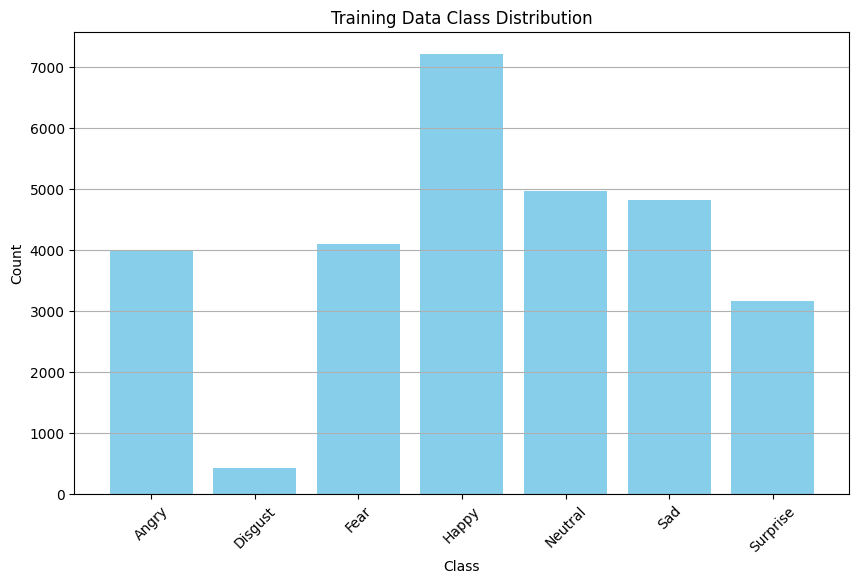

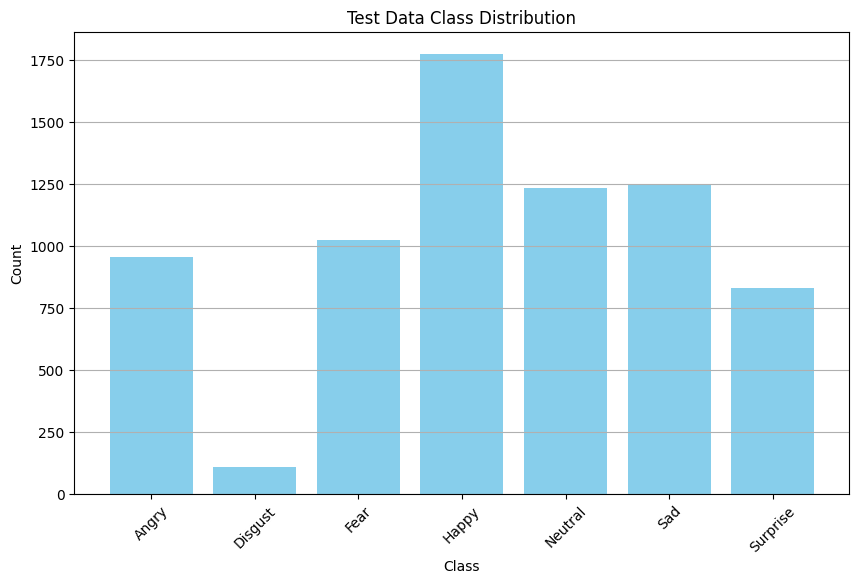

In [7]:
# EDA: Plotting class distributions
def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 6))
    plt.bar(unique, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(unique, label_encoder.inverse_transform(unique), rotation=45)
    plt.grid(axis='y')
    plt.show()

plot_class_distribution(train_labels, "Training Data Class Distribution")
plot_class_distribution(test_labels, "Test Data Class Distribution")

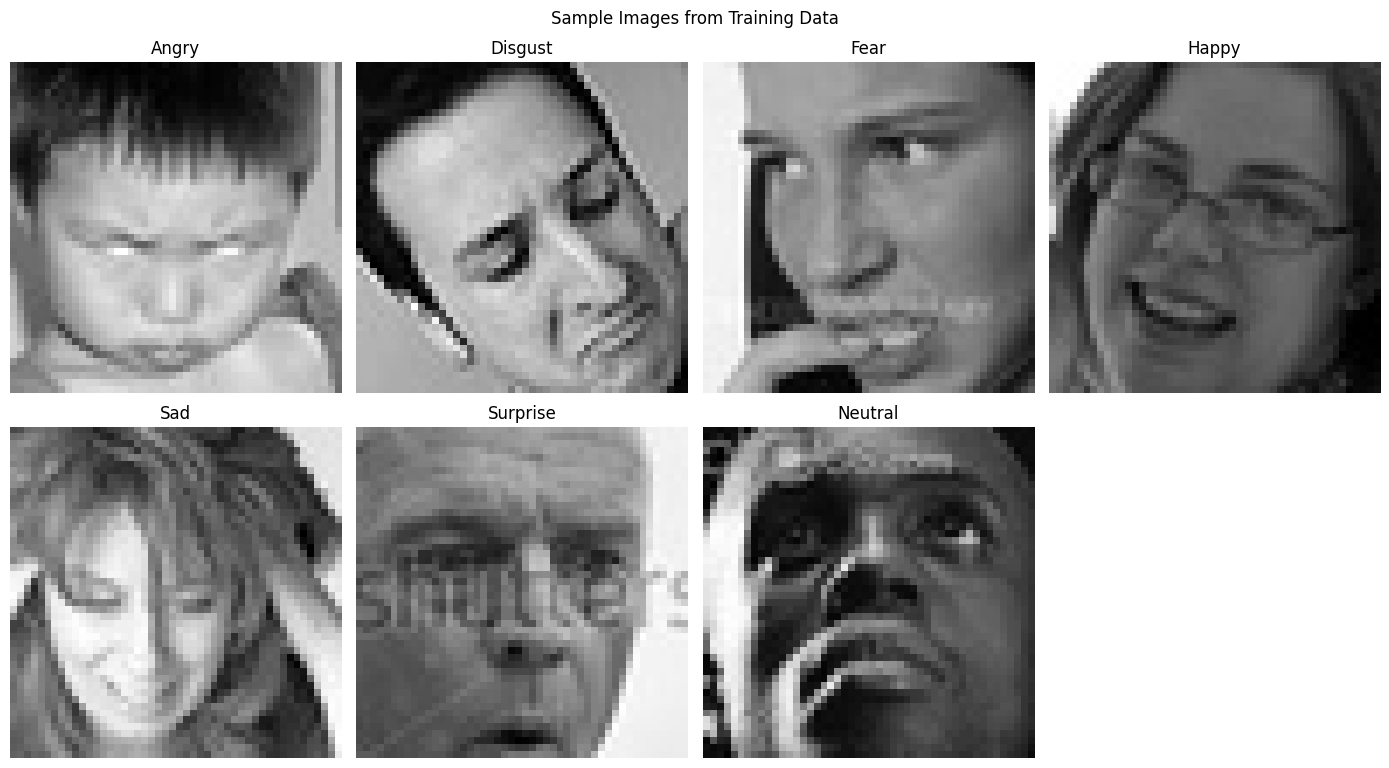

In [8]:
Display one image per class
def display_sample_images(images, labels, title):
    plt.figure(figsize=(14, 8))
    for i, emotion in enumerate(emotion_classes):
        idx = np.where(labels == label_encoder.transform([emotion])[0])[0][0]
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[idx].reshape(48, 48), cmap='gray')
        plt.title(emotion)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

display_sample_images(train_images, train_labels, "Sample Images from Training Data")

Vi använder dataaugmentation för att göra vårt träningsdataset mer varierat. Det är som att ge vår modell fler exempel att lära sig av genom att ändra bilderna lite, som att rotera eller vända dem. Detta hjälper vår modell att bli bättre på att känna igen olika saker i verkliga bilder och minskar risken för överanpassning.

In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


Modellen använder sig av konvolutionslager, som är lager som är speciellt utformade för att upptäcka mönster i bilder. Den använder sig av batch normalization som hjälper till att göra inlärningen effektiv, sedan använder den maxpooling som hjälper till att göra det lättare för modellen att förstå, sedan används dropout för att förhindra att modellen fokuserar för mycket på specifika funktioner och slutligen används täta lager för att tolka de extraherade funktionerna och förutsäga bilderna. Denna arkitektur används för bildklassificeringsuppgifter för att uppnå bättre noggrannhet.

In [10]:
# Define the model architecture
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(7, activation='softmax')
    ])
    return model

Adam-optimizer används för att den är effektiv och justerar inlärningshastigheten automatiskt. sparse_kategorisk crossentropi väljs som förlustfunktion eftersom vi arbetar med flera klasser. Metrics används för att mäta hur väl modellen presterar.

In [11]:
# Compile the model
model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


EarlyStopping stoppar träningen när valideringsförlusten slutar förbättras, vilket förhindrar överanpassning och återställer de bästa modellvikterna. ReduceLROnPlateau minskar inlärningshastigheten när prestandan planar ut, vilket hjälper modellen att konvergera. Modellen tränas i upp till 100 epoker med en batchstorlek på 32, och 20% av data används för validering.

In [12]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)

In [13]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=100,
                    steps_per_epoch=len(X_train) / 64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
358/358 [==============================] - 118s 323ms/step - loss: 2.3102 - accuracy: 0.2116 - val_loss: 1.8435 - val_accuracy: 0.2607 - lr: 0.0010
Epoch 2/100
358/358 [==============================] - 117s 327ms/step - loss: 1.8003 - accuracy: 0.3040 - val_loss: 1.6576 - val_accuracy: 0.3450 - lr: 0.0010
Epoch 3/100
358/358 [==============================] - 114s 317ms/step - loss: 1.6281 - accuracy: 0.3687 - val_loss: 1.5030 - val_accuracy: 0.4216 - lr: 0.0010
Epoch 4/100
358/358 [==============================] - 117s 325ms/step - loss: 1.5337 - accuracy: 0.4076 - val_loss: 1.4516 - val_accuracy: 0.4523 - lr: 0.0010
Epoch 5/100
358/358 [==============================] - 126s 352ms/step - loss: 1.4562 - accuracy: 0.4401 - val_loss: 1.3566 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 6/100
358/358 [==============================] - 119s 333ms/step - loss: 1.3982 - accuracy: 0.4652 - val_loss: 1.2728 - val_accuracy: 0.5110 - lr: 0.0010
Epoch 7/100
358/358 [===================

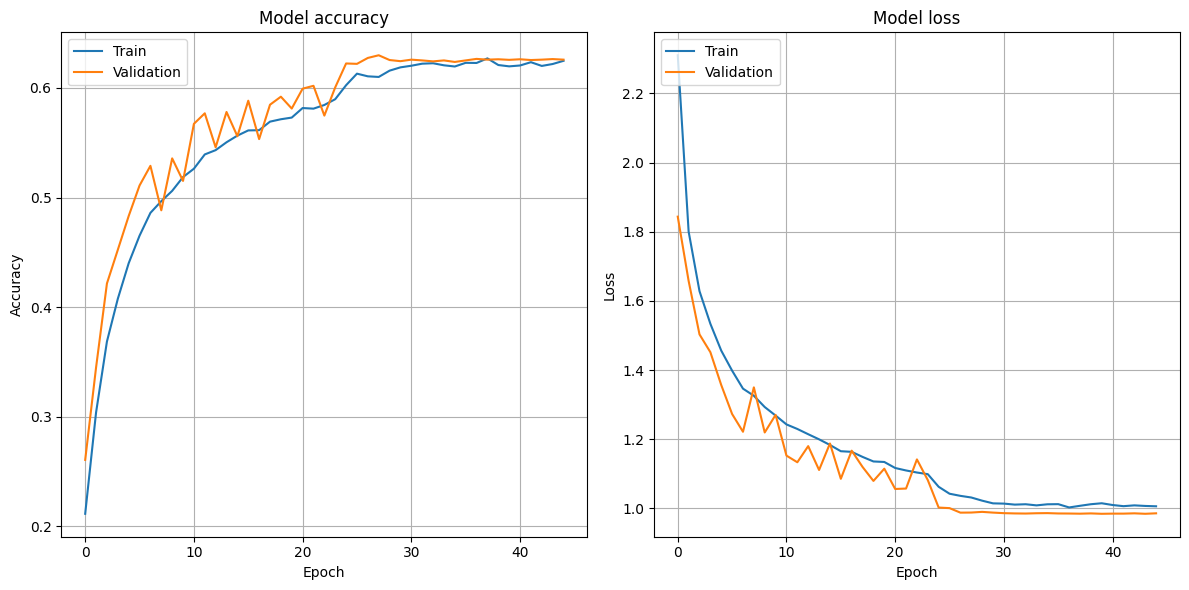

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


Genom att beräkna modellens förlust och noggrannhet på testdatauppsättningen utvärderar utvärderingstekniken hur väl modellen generaliserar till nya data.

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy:.4f}")

225/225 [==============================] - 7s 30ms/step - loss: 0.9828 - accuracy: 0.6346
Test accuracy: 0.6346


Confusion Matrix hjälper till att identifiera specifika klasser där modellen presterar bra eller behöver förbättras

225/225 [==============================] - 8s 33ms/step


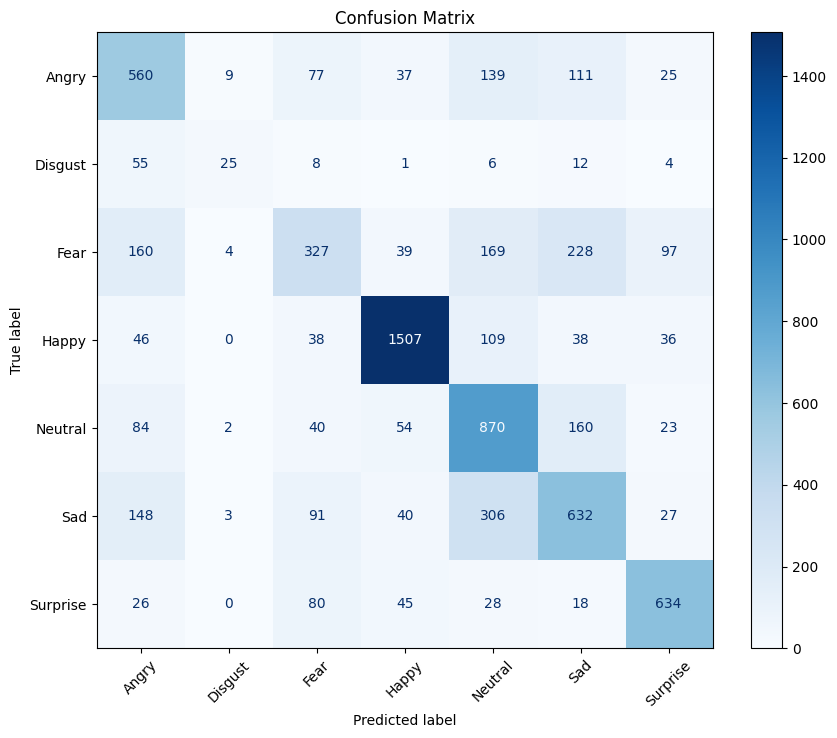

In [16]:
# Confusion Matrix
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(test_labels, y_pred_classes)

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=label_encoder.classes_).plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


In [17]:
# Save the entire model
model.save('RFER_model.h5')

Den här koden analyserar bilder för att avgöra vilka känslor som uttrycks i människors ansikten och visar resultaten visuellt.Koden laddar bilder, hittar ansikten i dem, förutsäger känslor för varje ansikte med hjälp av modellen och visar resultaten med rutor runt ansikten och etiketter som visar de förutspådda känslorna. Detta hjälper till att förstå hur bra modellen är på att känna igen känslor i olika situationer.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
Emotion: Angry, Image Path: C:\Users\Imthias\Downloads\Deep learning\images\1.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Emotion: Happy, Image Path: C:\Users\Imthias\Downloads\Deep learning\images\4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Emotion: Neutral, Image Path: C:\Users\Imthias\Downloads\Deep learning\images\6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Emotion: Surprise, Image Path: C:\Users\Imthias\Downloads\Deep learning\images\7.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Emotion: Sad, Image Path: C:\Users\Imthias\Downloads\Deep learning\images\8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Emotion: Fear, Image Path: C:\Users\Imthias\Downloads\Deep learning\images\34.jpg


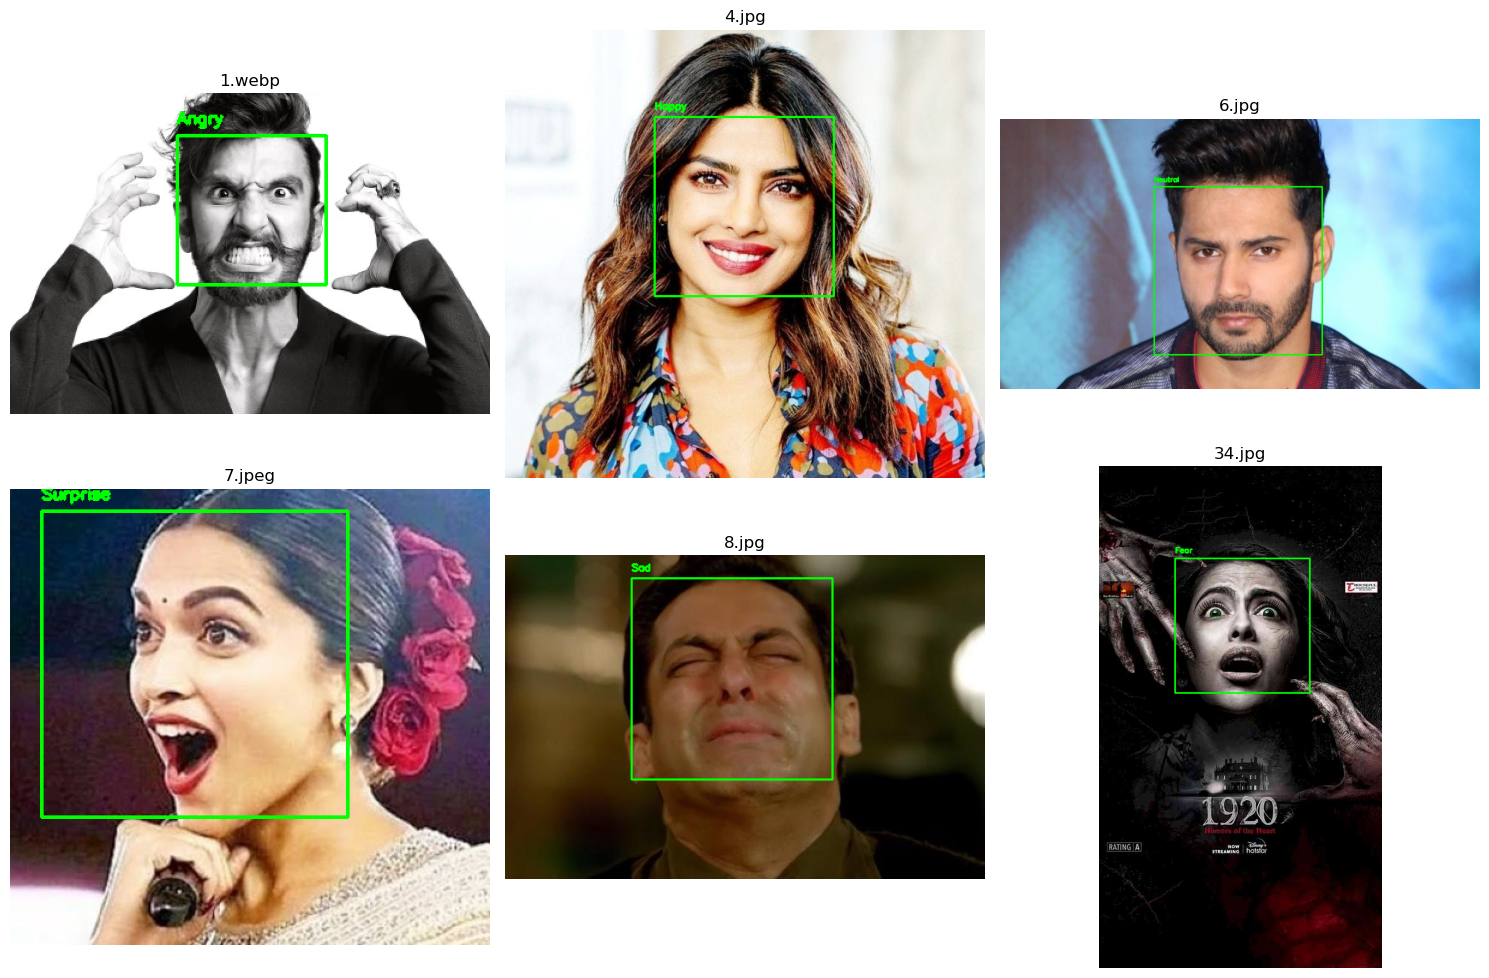

In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import os
import matplotlib.pyplot as plt

# Define the path and filename for the model
save_path = r"C:\Users\Imthias"
model_filename = "RFER_model.h5"
full_model_path = os.path.join(save_path, model_filename)

# Load the pre-trained emotion classifier model
model = load_model(full_model_path)

# Emotion labels based on the trained model
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# List of image paths to process
image_paths = [
    r"C:\Users\Imthias\Downloads\Deep learning\images\1.webp",
    r"C:\Users\Imthias\Downloads\Deep learning\images\4.jpg",
    r"C:\Users\Imthias\Downloads\Deep learning\images\6.jpg",
    r"C:\Users\Imthias\Downloads\Deep learning\images\7.jpeg",
    r"C:\Users\Imthias\Downloads\Deep learning\images\8.jpg",
    r"C:\Users\Imthias\Downloads\Deep learning\images\34.jpg"

]

# Determine the number of columns for the subplot grid
num_columns = 3
num_rows = (len(image_paths) + num_columns - 1) // num_columns  # Round up

# Create a figure for the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))
axes = axes.flatten()

# Process each image in the list
for idx, image_path in enumerate(image_paths):
    # Load the image
    image = cv2.imread(image_path)

    # Check if the image is loaded successfully
    if image is None:
        print(f"Error: Could not load image from path: {image_path}")
        continue

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load OpenCV's Haar Cascade for face detection from disk
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # Loop over the face detections
    for (x, y, w, h) in faces:
        # Extract the face ROI
        face = gray[y:y + h, x:x + w]

        # Preprocess the face ROI for the emotion classifier
        face = cv2.resize(face, (48, 48))
        face = face.astype("float") / 255.0
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0)

        # Predict the emotion
        preds = model.predict(face)[0]
        emotion_probability = np.max(preds)
        emotion_label = emotion_labels[preds.argmax()]

        # Draw the face bounding box and the emotion label
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

        # Print the emotion label and image path
        print(f"Emotion: {emotion_label}, Image Path: {image_path}")

    # Convert BGR image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the resulting image in the corresponding subplot
    axes[idx].imshow(image_rgb)
    axes[idx].set_title(f"{os.path.basename(image_path)}")
    axes[idx].axis('off')  # Hide axis

# Hide any empty subplots
for i in range(len(image_paths), len(axes)):
    axes[i].axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


Detta steg hur metoden för att upptäcka känslor kan utökas till en användbar applikation, som att göra musikrekommendationer beroende på användarens identifierade uttryck.Koden börjar med att hitta ansikten i en bild med hjälp av ett speciellt verktyg som kallas Haar Cascade. Sedan använder den en förtränad modell för att ta reda på hur personerna i dessa ansikten känner sig. Den fokuserar på känslor som glädje och sorg och föreslår låtar som matchar dessa känslor. Till sist visas bilden med ramar runt ansiktena och berättar vilka låtar som rekommenderas, vilket ger en bra uppfattning om hur bra modellen fungerar och gör hela upplevelsen mer interaktiv.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
Emotion: Happy, Mood: Positive Mood
Songs:
C:\Users\Imthias\Downloads\Deep learning\Happy\Besharam Rang - Pathaan.mp3
C:\Users\Imthias\Downloads\Deep learning\Happy\Chak De India.mp3
C:\Users\Imthias\Downloads\Deep learning\Happy\Dance monkey.mp3

Results for image: 4.jpg
Recommended Songs:
Emotion: Happy, Recommended Song: C:\Users\Imthias\Downloads\Deep learning\Happy\Dance monkey.mp3



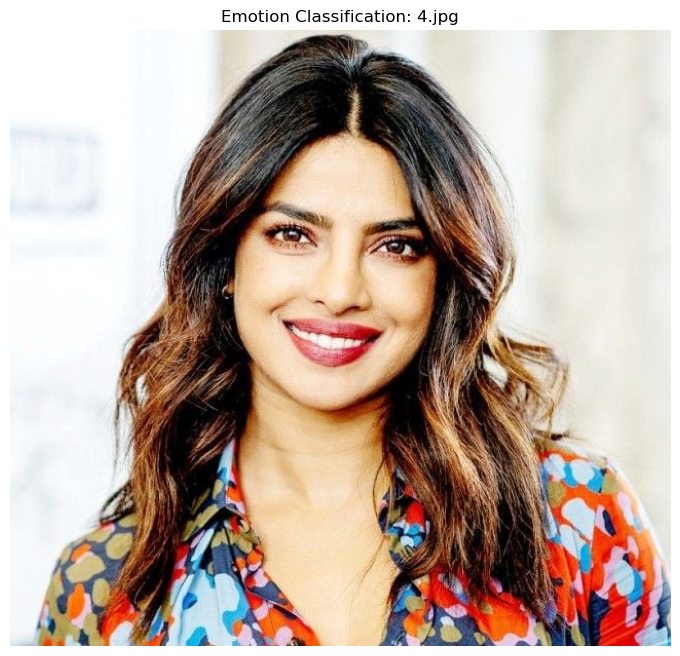

In [5]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import os
import random
import pygame
import matplotlib.pyplot as plt

# Initialize Pygame mixer
pygame.mixer.init()

# Define the path and filename for the model
model_path = r"C:\Users\Imthias\RFER_model.h5"

# Load the pre-trained emotion classifier model
model = load_model(model_path)

# Emotion labels based on the trained model
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Mapping from emotions to moods (focus on Happy and Sad)
emotion_to_mood = {
    'Happy': 'Positive Mood',
    'Sad': 'Negative Mood'
}

# Paths to song folders
mood_to_song_folder = {
    'Positive Mood': r"C:\Users\Imthias\Downloads\Deep learning\Happy",
    'Negative Mood': r"C:\Users\Imthias\Downloads\Deep learning\Sad"
}

# Function to recommend a song based on mood
def recommend_song(mood):
    song_folder = mood_to_song_folder[mood]
    song_files = os.listdir(song_folder)
    if not song_files:
        return None
    return os.path.join(song_folder, random.choice(song_files))

# Path to the single image to process
image_path = r"C:\Users\Imthias\Downloads\Deep learning\images\4.jpg"

# Load the image
image = cv2.imread(image_path)

# Check if the image is loaded successfully
if image is None:
    print(f"Error: Could not load image from path: {image_path}")
else:
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load OpenCV's Haar Cascade for face detection from disk
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # Dictionary to store recommended songs for each emotion
    recommended_songs = {}

    if len(faces) == 0:
        print(f"No faces detected in image: {os.path.basename(image_path)}")

    # Loop over the face detections
    for (x, y, w, h) in faces:
        # Extract the face ROI
        face = gray[y:y + h, x:x + w]

        # Preprocess the face ROI for the emotion classifier
        face = cv2.resize(face, (48, 48))
        face = face.astype("float") / 255.0
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0)

        # Predict the emotion
        preds = model.predict(face)[0]
        emotion_probability = np.max(preds)
        emotion_label = emotion_labels[preds.argmax()]

        # Only process Happy and Sad emotions
        if emotion_label in emotion_to_mood:
            # Map the detected emotion to a mood
            mood = emotion_to_mood[emotion_label]

            # Recommend a song based on the detected mood
            recommended_song = recommend_song(mood)

            if recommended_song:
                # Store the recommended song for the emotion
                recommended_songs[emotion_label] = recommended_song

            # Print all the songs in the directory for the emotion
            print(f"Emotion: {emotion_label}, Mood: {mood}")
            print("Songs:")
            for song_file in os.listdir(mood_to_song_folder[mood]):
                print(os.path.join(mood_to_song_folder[mood], song_file))
            print()

    # Print recommended songs for each emotion
    print(f"Results for image: {os.path.basename(image_path)}")
    if recommended_songs:
        print("Recommended Songs:")
        for emotion, song in recommended_songs.items():
            print(f"Emotion: {emotion}, Recommended Song: {song}")
    else:
        print("No Happy or Sad emotions detected.")
    print()

    # Convert BGR image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the resulting image with detected faces and emotion labels using matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.title(f"Emotion Classification: {os.path.basename(image_path)}")
    plt.axis('off')  # Hide axis
    plt.show()


1.	Utmaningar du haft under arbetet samt hur du hanterat dem. 
i faced  challenges in achieving high accuracy due to dataset variations. To address this, i implemented data augmentation to increase sample diversity and improve generalization. i adjusted model parameters, including architecture, learning rates, and batch sizes, to reduce overfitting and. i also utilized early stopping and learning rate reduction strategies to prevent overfitting during training. These efforts collectively refined the model and improved its overall performance.

2.	Vilket betyg du anser att du skall ha och varför. 
i think i understood the concept well and showed creativity by adding mood based song recommendations i think i should get approved grade.

3.	Tips du hade ”gett till dig själv” i början av kursen nu när du slutfört den. 
Try to understand things from the basics and explore everything you can. Don't stress out, just keep going and focus on understanding the concepts.